# Average Rent vs Shelter Occupancy Analysis

The Rental Market Data is extracted from Toronto Regional Real Estate Board's (TRREB) Rental Market Report Archive (http://trreb.ca/index.php/market-news/rental-market-report/rental-market-report-archive).

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from statsmodels.graphics.regressionplots import plot_regress_exog

%config InlineBackend.figure_format = 'retina'

# Load shelter occupancy data files

In [2]:
# Load files from GitHub; add year labels
path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Shelter%20Data/'
dso2017 = pd.read_csv(path + 'daily-shelter-occupancy-2017-csv.csv', 
                    parse_dates=['OCCUPANCY_DATE']); dso2017['source_file']=2017
dso2018 = pd.read_csv(path + 'daily-shelter-occupancy-2018-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2018['source_file']=2018
dso2019 = pd.read_csv(path + 'daily-shelter-occupancy-2019-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2019['source_file']=2019

In [3]:
# Concatenate DataFrames
daily_shelter_occupancy = pd.concat([dso2017, dso2018, dso2019], ignore_index=True) 

# Get list of column names; change to Python standard lowercase:
cols = [column_name.lower() for column_name in daily_shelter_occupancy.columns] 
daily_shelter_occupancy.columns = cols

# Move source_file column to front of DataFrame
cols = cols[-1:] + cols[0:-1]
daily_shelter_occupancy = daily_shelter_occupancy[cols]

# Show sample records
daily_shelter_occupancy.head()

,source_file,_id,occupancy_date,organization_name,shelter_name,shelter_address,shelter_city,shelter_province,shelter_postal_code,facility_name,program_name,sector,occupancy,capacity
0,2017,1,2017-01-01,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0
1,2017,2,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0
2,2017,3,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0
3,2017,4,2017-01-01,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0
4,2017,5,2017-01-01,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0


In [4]:
# Identify columns with missing values:
for col in daily_shelter_occupancy.columns:
  null_count = daily_shelter_occupancy[col].isna().sum()
  if null_count >0:
    print(f'The {col} column has {null_count} rows without values.')

The shelter_postal_code column has 5494 rows without values.
The capacity column has 343 rows without values.


In [5]:
# Drop 343 rows with null capacity
original_row_count=daily_shelter_occupancy.shape[0]
daily_shelter_occupancy.dropna(subset=['capacity'], inplace=True)
dropped_row_count=original_row_count-daily_shelter_occupancy.shape[0]
print(f'Dropped {dropped_row_count} of {original_row_count} rows, due to nulls in capacity column.')

# After removing nulls, change capacity column to integer
daily_shelter_occupancy.capacity = daily_shelter_occupancy.capacity.astype(int)

Dropped 343 of 115916 rows, due to nulls in capacity column.


In [6]:
#create daily downsample with new vacancy and occupancy_rate columns
daily = daily_shelter_occupancy.set_index('occupancy_date')\
  .resample('D')[['occupancy','capacity']].sum()
daily['vacancy']=daily.capacity - daily.occupancy
daily['occupancy_rate']=daily.occupancy/daily.capacity*100

#create quarterly sample for analysis
quarterly = daily.resample('Q')[['occupancy']].mean()
quarterly

,occupancy
occupancy_date,
2017-03-31,4603.988889
2017-06-30,4827.637363
2017-09-30,4950.880435
2017-12-31,5183.271739
2018-03-31,5850.255556
2018-06-30,6489.692308
2018-09-30,6483.793478
2018-12-31,6625.978261
2019-03-31,6842.422222


# Load TRREB Quarterly Rental Market Data file

In [7]:
TRREBpath = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Rental%20Data/'

trrebData = pd.read_csv(TRREBpath + 'TRREB-Quarterly-Data.csv')
trrebData['Average'] = pd.to_numeric(trrebData['Average'])
trrebData['rent_date'] = pd.to_datetime(trrebData['rent_date'])
trrebData = trrebData.set_index('rent_date')

trrebData

,Average
rent_date,
2017-03-31,1791
2017-06-30,1861
2017-09-30,1976
2017-12-31,1970
2018-03-31,1995
2018-06-30,2055
2018-09-30,2163
2018-12-31,2143
2019-03-31,2143


In [8]:
df = trrebData.join(quarterly)
df

,Average,occupancy
rent_date,,
2017-03-31,1791,4603.988889
2017-06-30,1861,4827.637363
2017-09-30,1976,4950.880435
2017-12-31,1970,5183.271739
2018-03-31,1995,5850.255556
2018-06-30,2055,6489.692308
2018-09-30,2163,6483.793478
2018-12-31,2143,6625.978261
2019-03-31,2143,6842.422222


# Time series plots for both datasets

Text(0.5, 1.0, 'Occupancy time series plot')

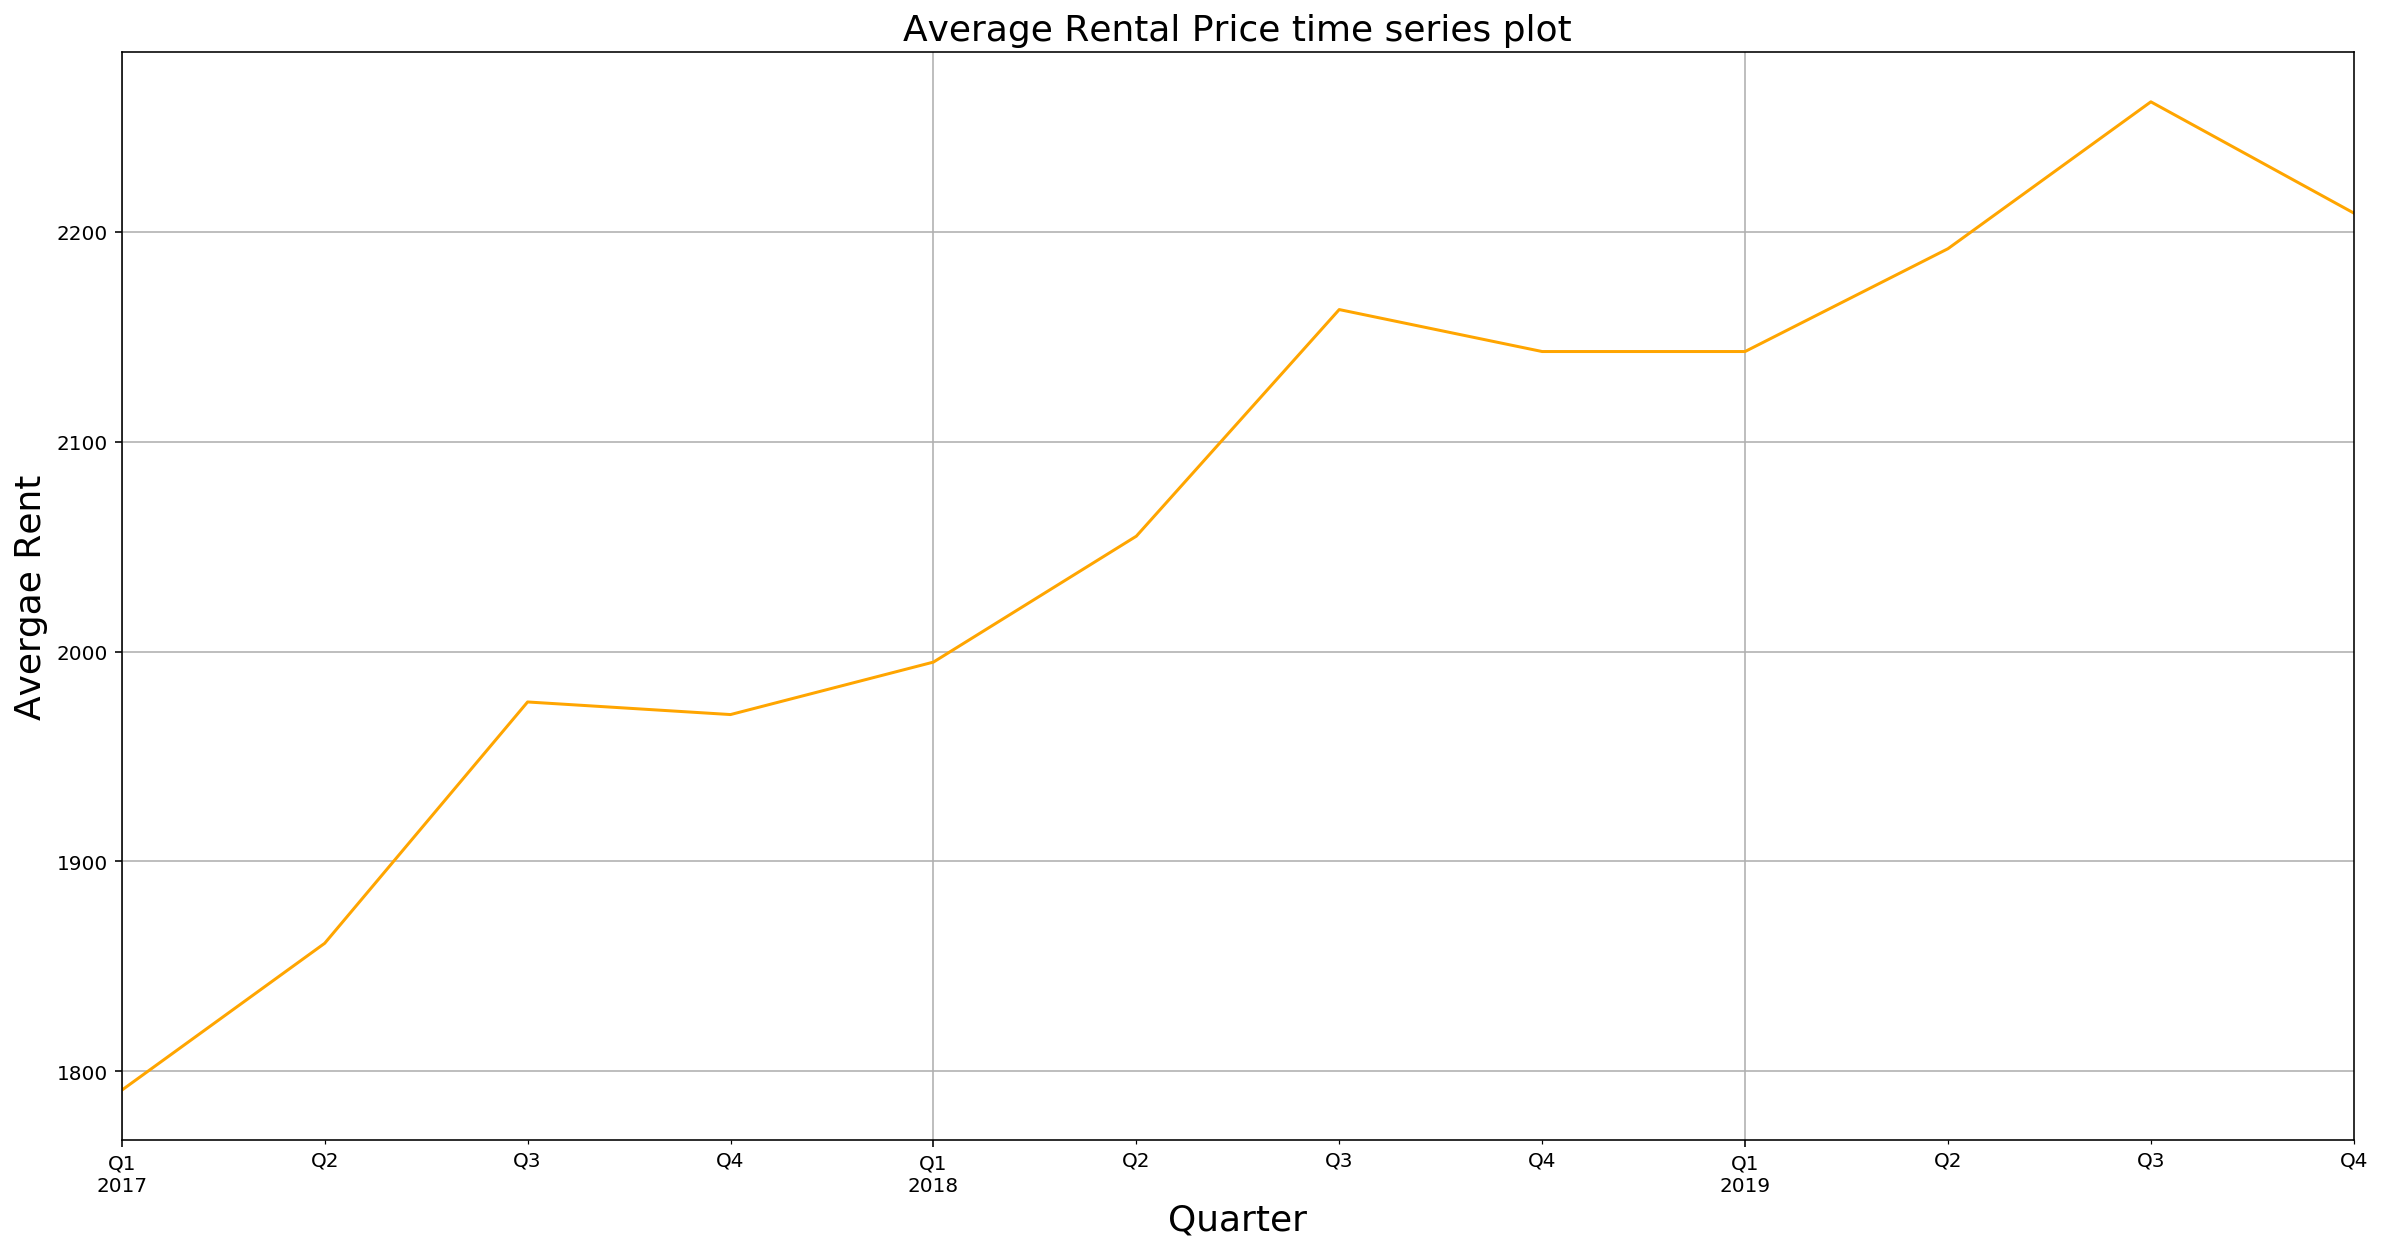

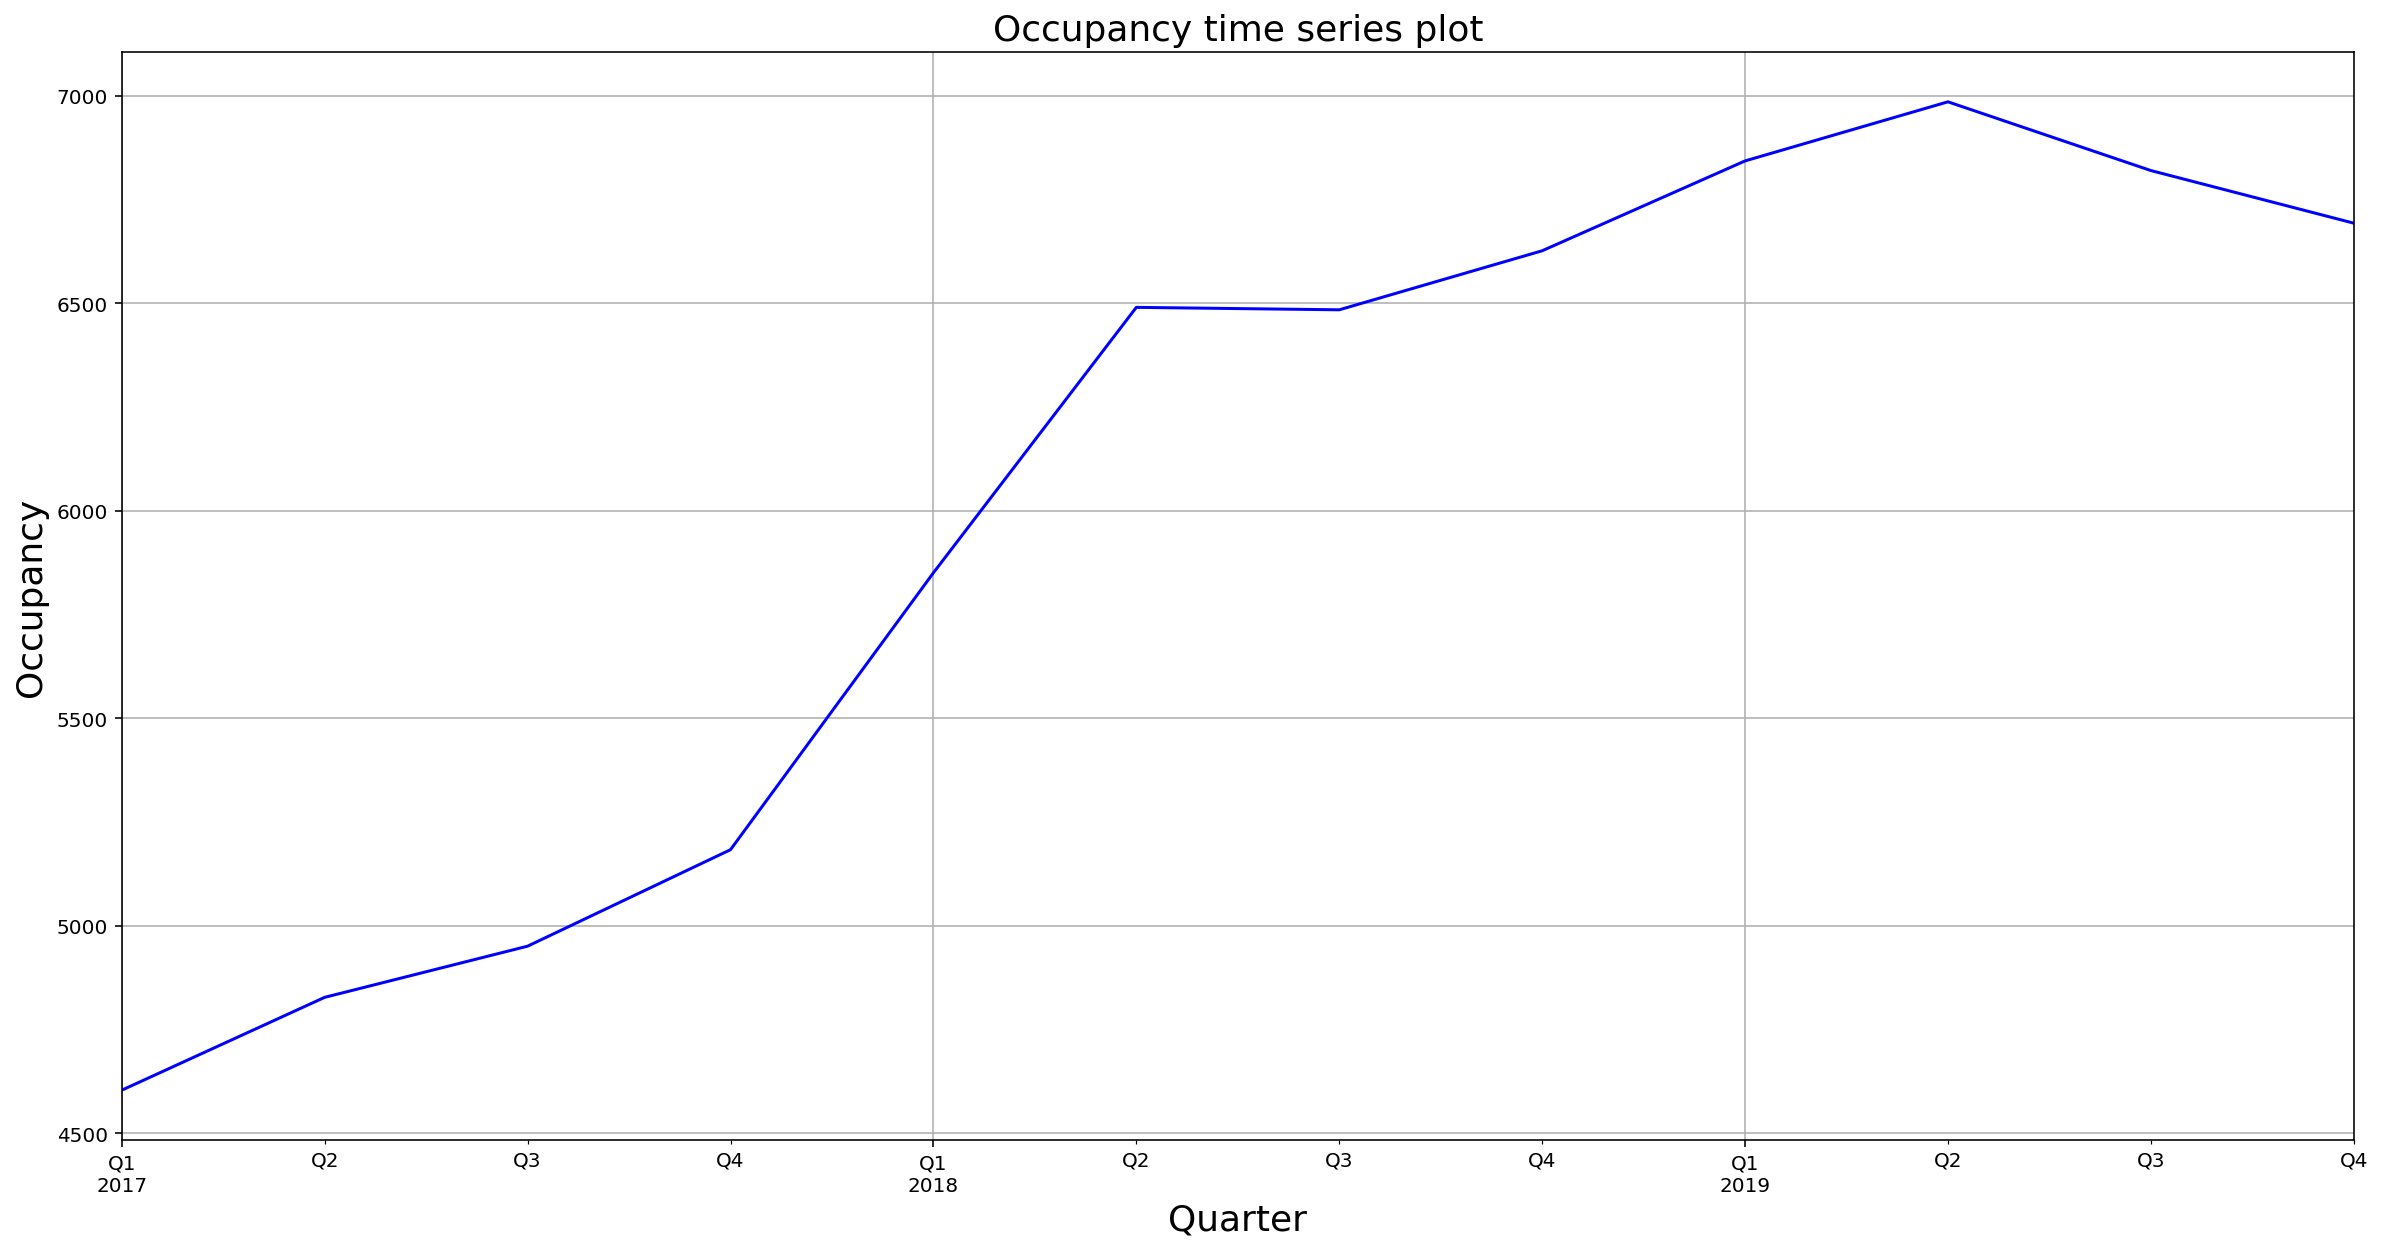

In [9]:
plt.figure()
df.Average.plot(grid=True, color='orange', figsize=(20,10))
plt.xlabel('Quarter', size=18)
plt.ylabel('Avergae Rent', size=18)
plt.title('Average Rental Price time series plot', size=18)


plt.figure()
df.occupancy.plot(grid=True, color='blue', figsize=(20,10))
plt.xlabel('Quarter', size=18)
plt.ylabel('Occupancy', size=18)
plt.title('Occupancy time series plot', size=18)

We can see a similar trend in time series plot for both, average rent and shelter occupancy

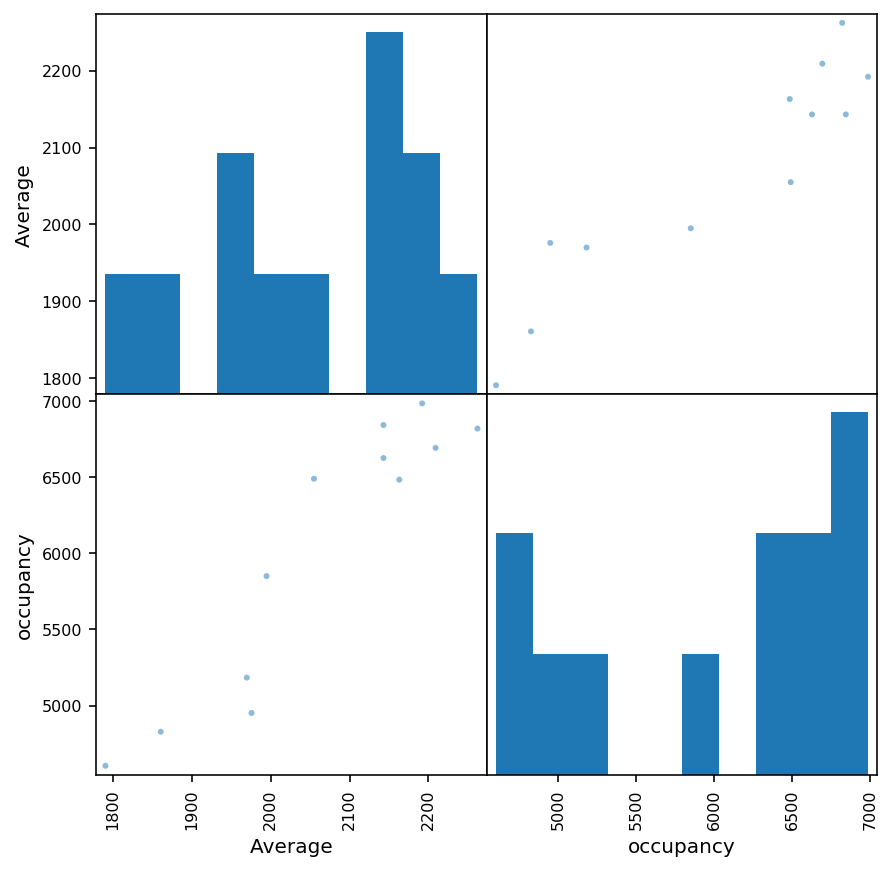

In [10]:
pd.plotting.scatter_matrix(quarterly.join(trrebData)[['Average', 'occupancy']], figsize= (7,7));

In [11]:
df[['Average','occupancy']].corr()

,Average,occupancy
Average,1.00000,0.93461
occupancy,0.93461,1.00000


# Linear Regression

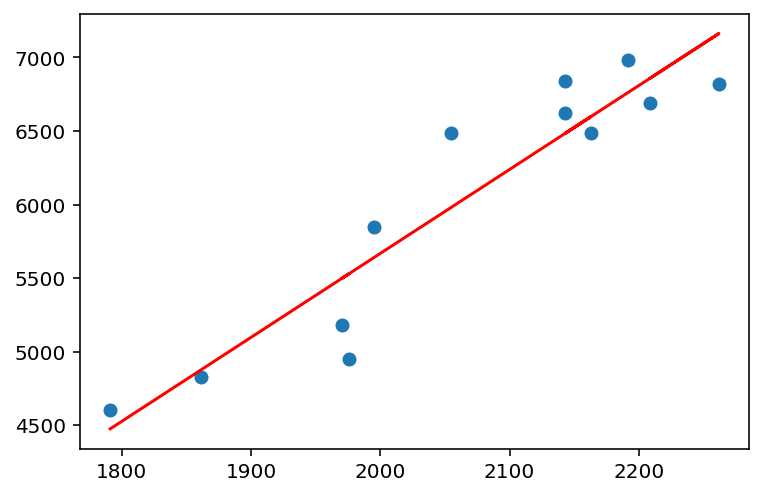

In [12]:
m = sm.ols('occupancy ~ Average', data = df)
m = m.fit()

intercept, slope = m.params
df['y_est'] = intercept + slope * df.Average
df['Residuals'] = df['y_est'] - df['occupancy']

plt.plot(df.Average, df.occupancy,'o')
plt.plot(df.Average, df.y_est, 'r-')
plt.show()

In [13]:
m.summary()

C:\Users\mohit\Anaconda3\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              occupancy   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     69.05
Date:                Thu, 06 Aug 2020   Prob (F-statistic):           8.43e-06
Time:                        11:48:55   Log-Likelihood:                -85.654
No. Observations:                  12   AIC:                             175.3
Df Residuals:                      10   BIC:                             176.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5744.1066   1420.144     -4.045      0.002   -8908.384   -2579.830
Average        5.7061      0.687      8.310      0.000       4.176       7.236
==============================================================================
Omnibus:                        0.263   Durbin-Watson:                   1.453
Prob(Omnibus):                  0.877   Jarque-Bera (JB):                0.417
Skew:                          -0.211   Prob(JB):                        0.812
Kurtosis:                       2.189   Cond. No.                     3.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

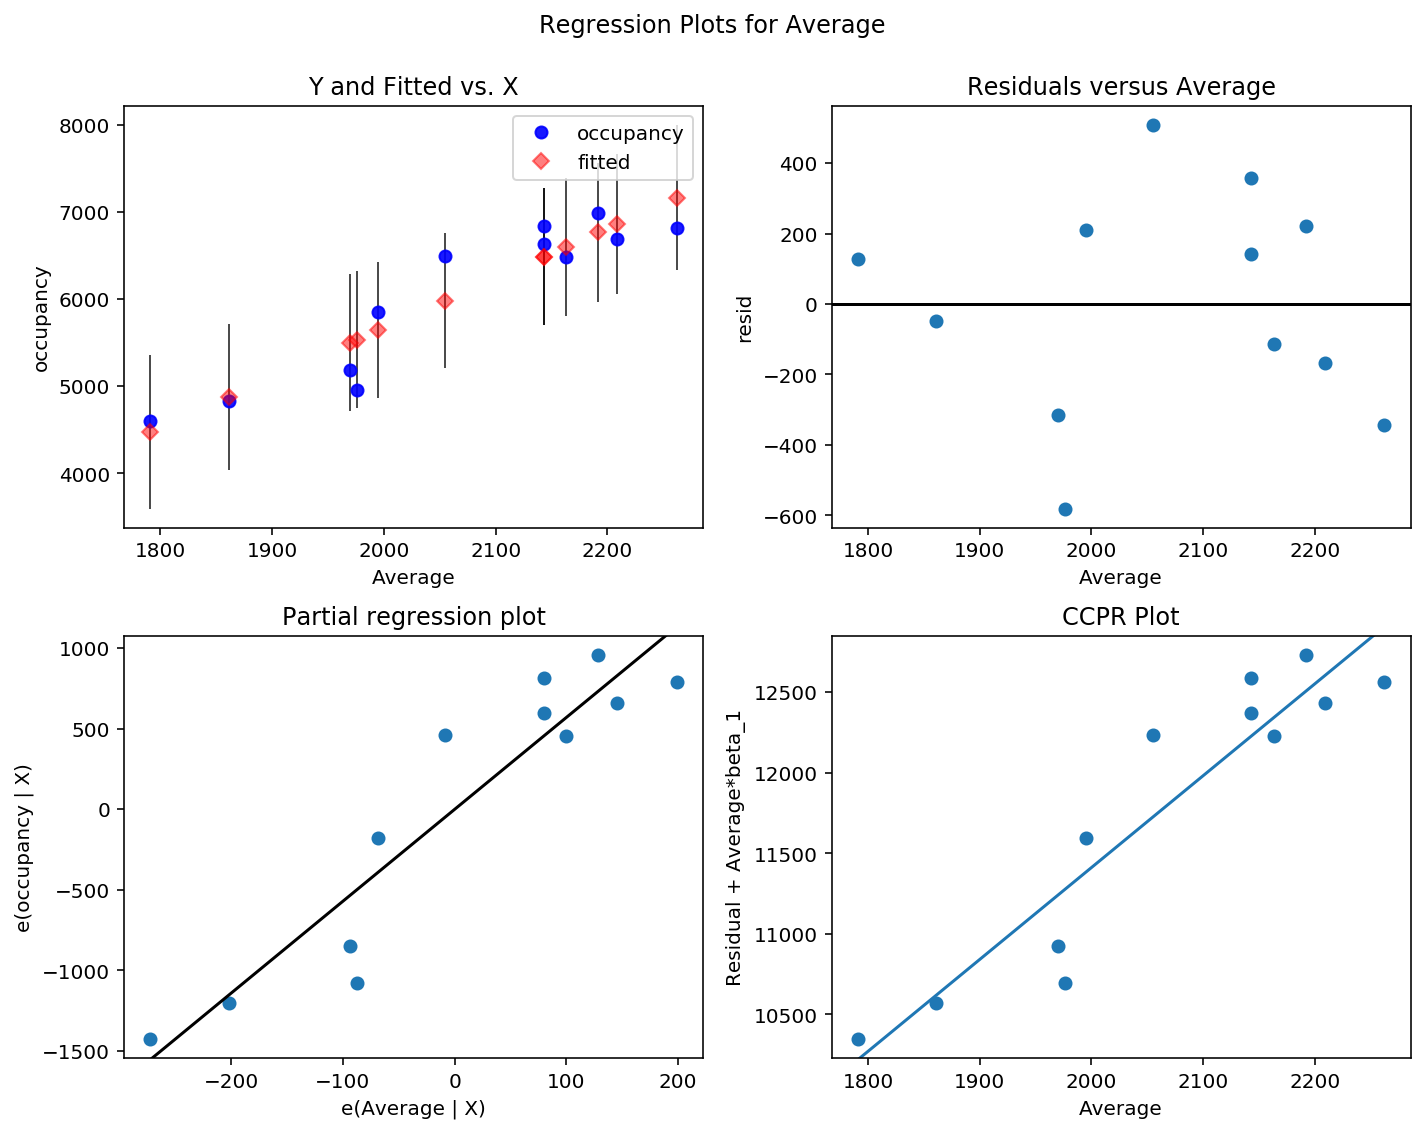

In [14]:
fig = plt.figure(figsize=(10,8))
fig = plot_regress_exog(m, "Average", fig = fig)

From the regression summary, we can see that the R-sqaured value is significant at 0.873. This shows that increasing accomodation cost in the three year span correlates with the increase in shelter occupancy in the same time frame.